# ***Building DataFrames***

---



In [ ]:
#initial imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage 
import cv2
from PIL import Image
import matplotlib as mpl

#!pip install read-roi
from read_roi import read_roi_zip


In [ ]:
#if files on drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#open image as 3d array, where first 2 dimensions correspond to image for each frame

file_path='PATH_TO_IMG/IMAGE.tif'
dataset = Image.open(file_path)
h,w = np.shape(dataset)
tiffarray = np.zeros((h,w,dataset.n_frames))
for i in range(dataset.n_frames):
   dataset.seek(i)
   tiffarray[:,:,i] = np.array(dataset)
expim = tiffarray.astype(np.uint8);



In [ ]:
#get roi coordinates

rois = read_roi_zip('PATH_TO_FOLDER/RoiSet.zip') #opens roiset file
rois = pd.DataFrame(rois).transpose()

#adds index to particle, allowing us to associate particles for different time frames
contourname = []
timeframe = []
for i, row in rois.iterrows():
  name = row['name']
  ind_start = name.find('#')
  ind_end = name.find('(')
  new_name = name[ind_start + 1 : ind_end-1]
  pos = row['position']
  new_pos =int(pos['frame'])
  contourname.append(new_name)
  timeframe.append(new_pos)

rois['particle'] = contourname
rois['timeframe'] = timeframe

#group by short name and count occurrences - eliminate particles which are not present in all 21 frames
contourcounts = rois.groupby(['particle']).size()
print(contourcounts[contourcounts<21]) #this is personalized to a 21-frame-long image

rois = rois[rois.groupby(['particle'])['particle'].transform('size')>20]

rois.index = rois['particle'].values
rois = rois.sort_values(by='timeframe') #sorting by timeframe

#adding bb limits, to obtain patch later
topx = []
width = []
topy = []
height = []

for ind, row in rois.iterrows():

  minx = np.min(row['x'])
  topx.append(minx)
  width.append(np.max(row['x'])-minx)

  miny = np.min(row['y'])
  topy.append(miny)
  height.append(np.max(row['y'])-miny)

rois['bbx'] = topx
rois['w'] = width
rois['bby'] = topy
rois['h'] = height

#drop unused columns
rois = rois.drop(columns=['type','n','width','name','position'])
rois



In [ ]:
#obtain the patches and input into new dataframe

df_patches = pd.DataFrame() #intensity patches
df_bb = pd.DataFrame() #bounding boxes
df_contours = pd.DataFrame() #contour-only

no_nuclei = np.unique(rois['particle'])

patches_dfroi = list(np.zeros(rois.shape[0])) #add patches to main df
centroids = list([None]*rois.shape[0])
centroids_x = list(np.zeros(rois.shape[0]))
centroids_y = list(np.zeros(rois.shape[0]))

rois_c = rois.copy()
rois_c.index = np.arange(rois_c.shape[0])

for nmb in no_nuclei:
  rois_temp = rois_c.loc[rois_c['particle'] == nmb] #work with one particle at a time
  rois_temp = rois_temp.sort_values(by = 'timeframe')
  index_dfroi = rois_temp.index
  rois_temp.index = np.arange(rois_temp.shape[0])

  patches = []
  bbs = []
  contours = []
  for ind, row in rois_temp.iterrows(): #one timeframe at a time
    time = row['timeframe']
    topx = int(np.floor(row['bbx']))
    if topx < 0:
      topx = 0
    topy = int(np.floor(row['bby']))
    if topy < 0:
      topy = 0
    bottomx = int(np.ceil(row['bbx'] + row['w'])) #bb coordinates point to top left corner if bounding box. add height and width fo obtain total coordinates
    bottomy = int(np.ceil(row['bby'] + row['h']))
    img = expim[:,:,ind] #opens image

    x_coords = row['x']
    y_coords = row['y']
    coords = np.array(np.transpose(np.vstack((x_coords,y_coords))))
    coords = np.rint(coords).astype(np.int32)
    mask = np.zeros((img.shape[0], img.shape[1])) #create one mask of entire image for each roi

    cv2.fillConvexPoly(mask, coords, 1)
    mask = mask.astype(np.bool) #mask is binary

    out = np.zeros_like(img)
    out[mask] = img[mask] #image from mask, but keeping original intensities where mask== true

    patch = np.array(out[topy:bottomy,topx:bottomx]) # patch is a bb created from the mask that keeps original intensities
    
    #getting centroid location for patches, in relation to image
    bin_patch = (patch!=0)*1
    props = regionprops(bin_patch,patch)
    centroid = props[0].centroid

    coords = list([row['bbx'] + centroid[0],row['bby'] + centroid[1]])
    coordsx = coords[0]
    coordsy = coords[1]



    #creates contour
    ret,patchbin = cv2.threshold(patch,0,255,cv2.THRESH_BINARY)
    # Find largest contour in intermediate image
    cnts, hierarqy = cv2.findContours(patchbin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)
    # Output
    cntr = np.zeros(patch.shape, np.uint8)
    cv2.drawContours(cntr, cnt, -1, 255, cv2.FILLED)

    patches_dfroi[index_dfroi[ind]] = patch #saves patch in main df
    centroids[index_dfroi[ind]] = coords
    centroids_x[index_dfroi[ind]] = coordsx
    centroids_y[index_dfroi[ind]] = coordsy
    


    patches.append(patch) #saves all patches
    contours.append(cntr) #saves all contours
    bbs.append([topy,topx,bottomy-topy,bottomx-topx]) #saves all bb coordinates


  df_patches[nmb] = patches
  df_bb[nmb] = bbs
  df_contours[nmb] = contours


#add patches to main df
rois['Patch'] = patches_dfroi
rois['centroid'] = centroids
rois['centroid x'] = centroids_x
rois['centroid y'] = centroids_y

df_patches = df_patches.transpose()
df_patches.index = np.arange(df_patches.shape[0])
df_bb = df_bb.transpose()
df_bb.index = np.arange(df_patches.shape[0])
df_contours = df_contours.transpose()
df_contours.index = np.arange(df_contours.shape[0])

#reindexing
particles_un = np.unique(rois['particle'])
particles = rois['particle'].values
new_ind = rois['particle'].values
for j,el in enumerate(particles_un):
  where = np.where(particles == el)
  new_ind[where[0]] = j

rois.index = new_ind
rois['particle'] = new_ind

#reassigning timeframe
timeframes = rois['timeframe'] - 1
rois['timeframe'] = timeframes




rois

In [ ]:
#obtain the patches and input into new dataframe

df_patches = pd.DataFrame() #intensity patches
df_bb = pd.DataFrame() #bounding boxes
df_contours = pd.DataFrame() #contour-only

no_nuclei = np.unique(rois['particle'])

patches_dfroi = list(np.zeros(rois.shape[0])) #add patches to main df
centroids = list([None]*rois.shape[0])
centroids_x = list(np.zeros(rois.shape[0]))
centroids_y = list(np.zeros(rois.shape[0]))

rois_c = rois.copy()
rois_c.index = np.arange(rois_c.shape[0])

for nmb in no_nuclei:
  rois_temp = rois_c.loc[rois_c['particle'] == nmb] #work with one particle at a time
  rois_temp = rois_temp.sort_values(by = 'timeframe')
  index_dfroi = rois_temp.index
  rois_temp.index = np.arange(rois_temp.shape[0])

  patches = []
  bbs = []
  contours = []
  for ind, row in rois_temp.iterrows(): #one timeframe at a time
    time = row['timeframe']
    topx = int(np.floor(row['bbx']))
    if topx < 0:
      topx = 0
    topy = int(np.floor(row['bby']))
    if topy < 0:
      topy = 0
    bottomx = int(np.ceil(row['bbx'] + row['w'])) #bb coordinates point to top left corner if bounding box. add height and width fo obtain total coordinates
    bottomy = int(np.ceil(row['bby'] + row['h']))
    img = expim[:,:,ind] #opens image

    x_coords = row['x']
    y_coords = row['y']
    coords = np.array(np.transpose(np.vstack((x_coords,y_coords))))
    coords = np.rint(coords).astype(np.int32)
    mask = np.zeros((img.shape[0], img.shape[1])) #create one mask of entire image for each roi

    cv2.fillConvexPoly(mask, coords, 1)
    mask = mask.astype(np.bool) #mask is binary

    out = np.zeros_like(img)
    out[mask] = img[mask] #image from mask, but keeping original intensities where mask== true

    patch = np.array(out[topy:bottomy,topx:bottomx]) # patch is a bb created from the mask that keeps original intensities
    
    #getting centroid location for patches, in relation to image
    bin_patch = (patch!=0)*1
    props = regionprops(bin_patch,patch)
    centroid = props[0].centroid

    coords = list([row['bbx'] + centroid[0],row['bby'] + centroid[1]])
    coordsx = coords[0]
    coordsy = coords[1]



    #creates contour
    ret,patchbin = cv2.threshold(patch,0,255,cv2.THRESH_BINARY)
    # Find largest contour in intermediate image
    cnts, hierarqy = cv2.findContours(patchbin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(cnts, key=cv2.contourArea)
    # Output
    cntr = np.zeros(patch.shape, np.uint8)
    cv2.drawContours(cntr, cnt, -1, 255, cv2.FILLED)

    patches_dfroi[index_dfroi[ind]] = patch #saves patch in main df
    centroids[index_dfroi[ind]] = coords
    centroids_x[index_dfroi[ind]] = coordsx
    centroids_y[index_dfroi[ind]] = coordsy
    


    patches.append(patch) #saves all patches
    contours.append(cntr) #saves all contours
    bbs.append([topy,topx,bottomy-topy,bottomx-topx]) #saves all bb coordinates


  df_patches[nmb] = patches
  df_bb[nmb] = bbs
  df_contours[nmb] = contours

#print(centroids)
#print(len(centroids))

#add patches to main df
rois['Patch'] = patches_dfroi
rois['centroid'] = centroids
rois['centroid x'] = centroids_x
rois['centroid y'] = centroids_y

#print(rois.loc[rois['particle']==72]['centroid'])

df_patches = df_patches.transpose()
df_patches.index = np.arange(df_patches.shape[0])
df_bb = df_bb.transpose()
df_bb.index = np.arange(df_patches.shape[0])
df_contours = df_contours.transpose()
df_contours.index = np.arange(df_contours.shape[0])

#reindexing
particles_un = np.unique(rois['particle'])
particles = rois['particle'].values
new_ind = rois['particle'].values
for j,el in enumerate(particles_un):
  where = np.where(particles == el)
  new_ind[where[0]] = j

rois.index = new_ind
rois['particle'] = new_ind

#reassigning timeframe
timeframes = rois['timeframe'] - 1
rois['timeframe'] = timeframes



rois

In [ ]:
#save dataframte

df_patches.to_pickle('OUTPUT_PATH/patches.pickle')
df_bb.to_pickle('OUTPUT_PATH/bbs.pickle')
df_contours.to_pickle('OUTPUT_PATH/contours.pickle')
rois.to_pickle('OUTPUT_PATH/dfroi.pickle')

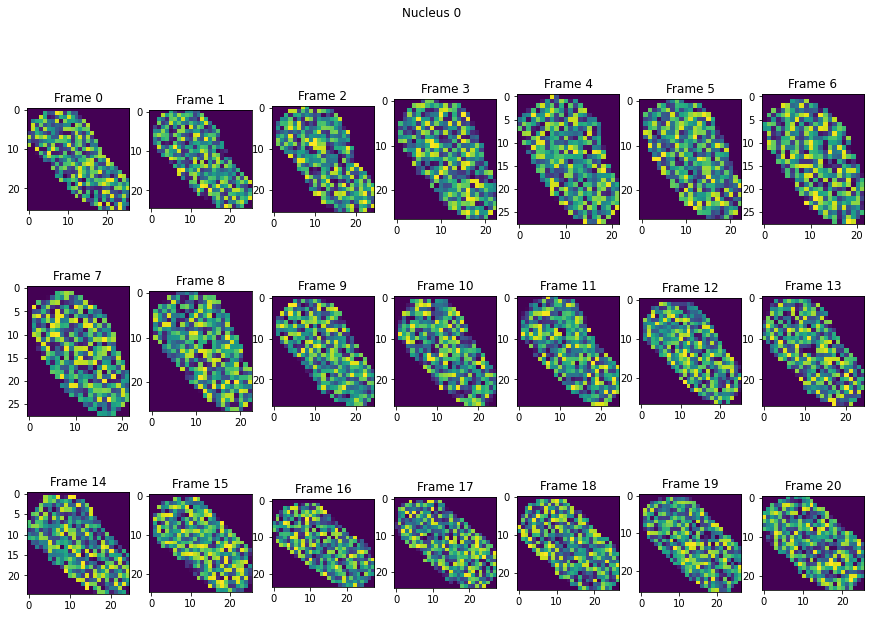

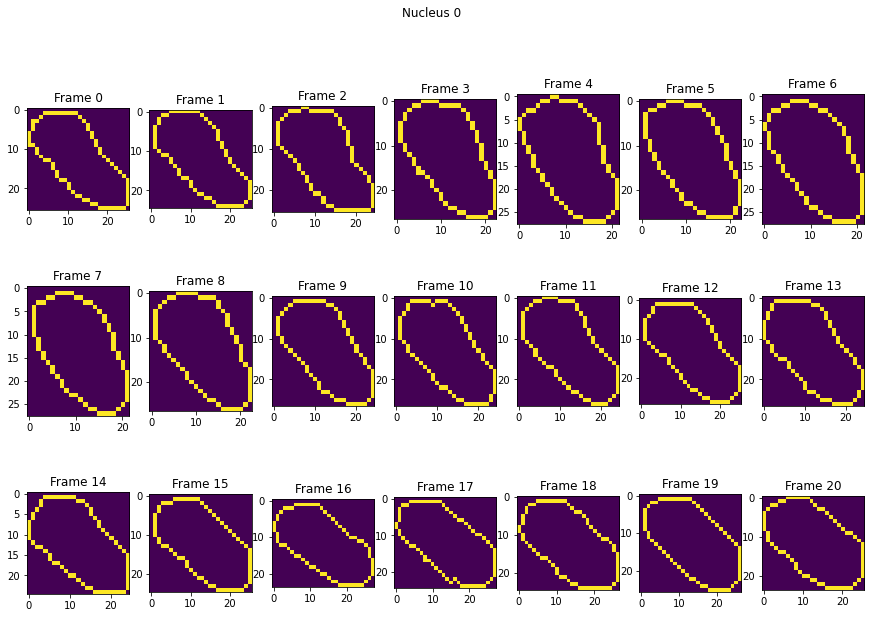

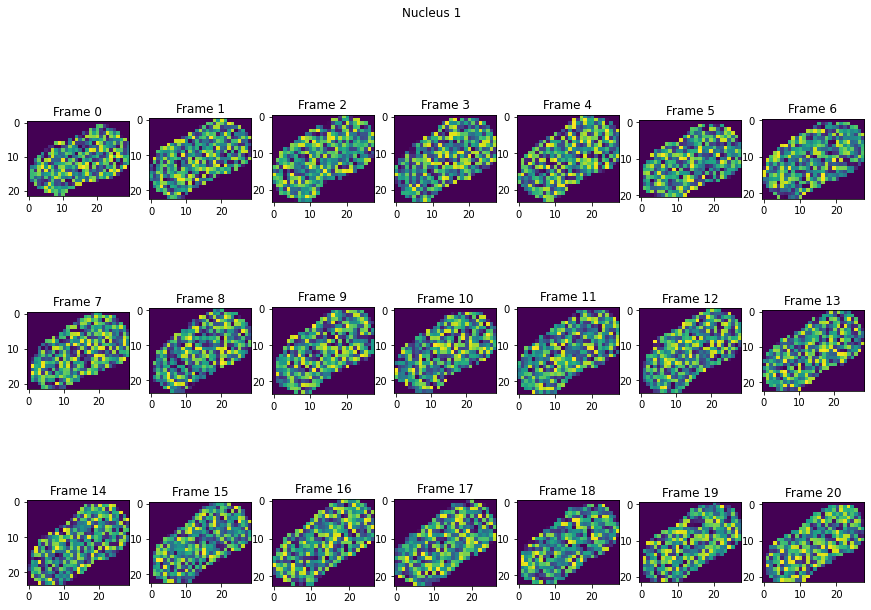

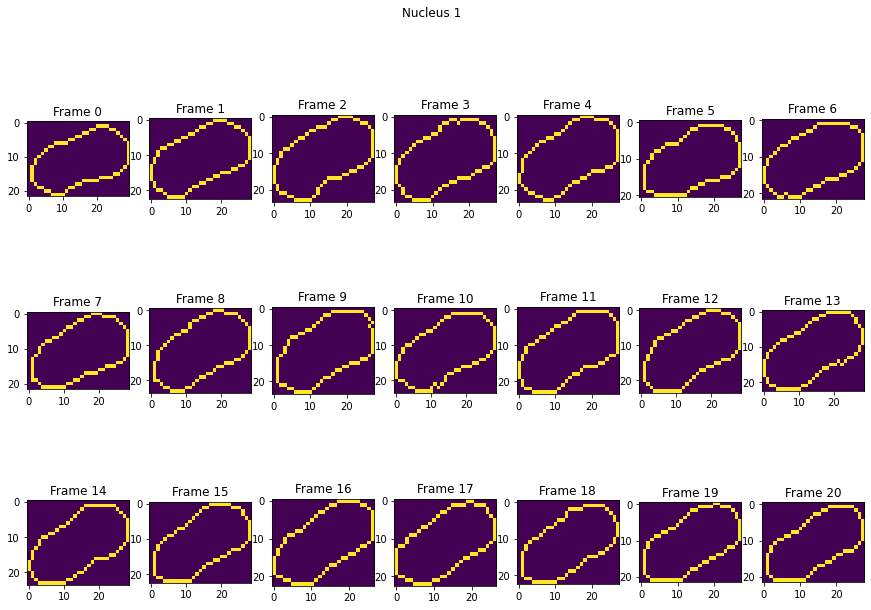

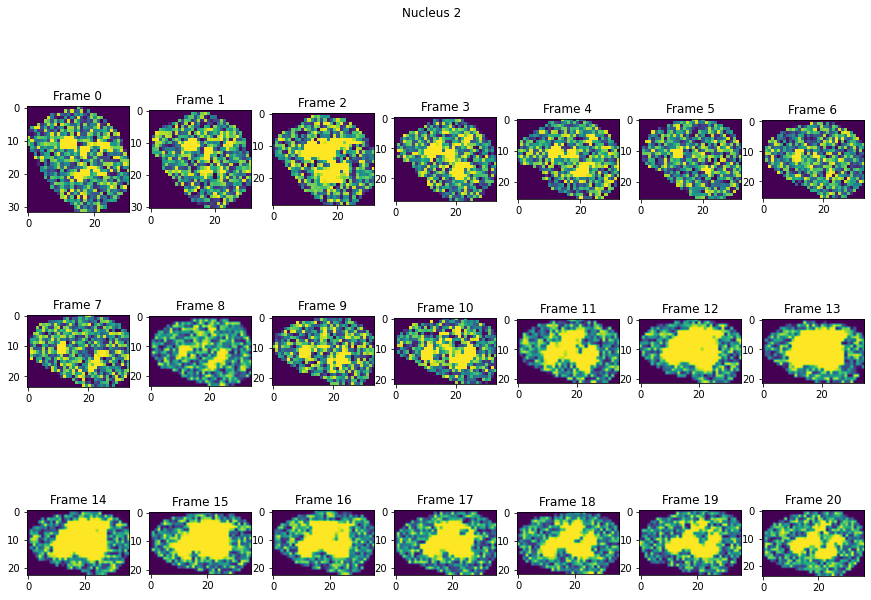

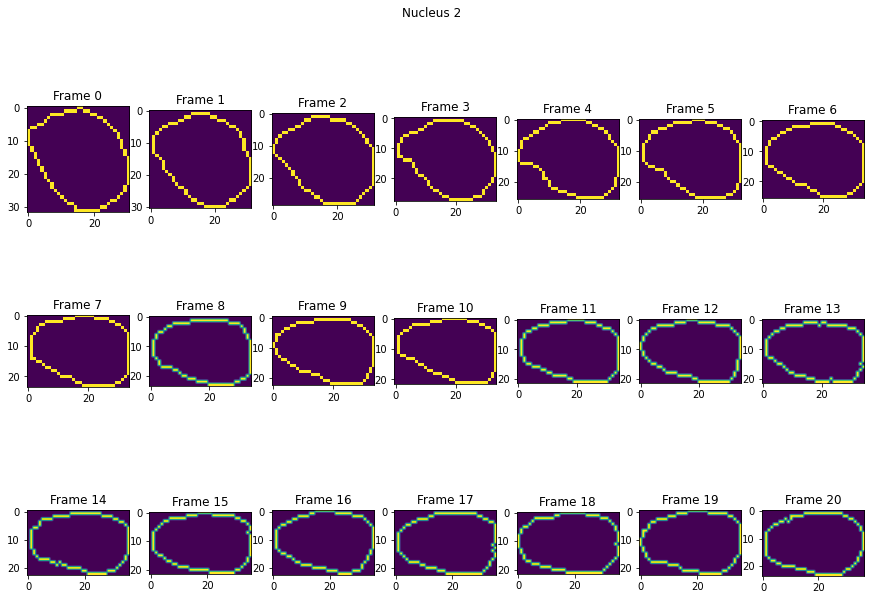

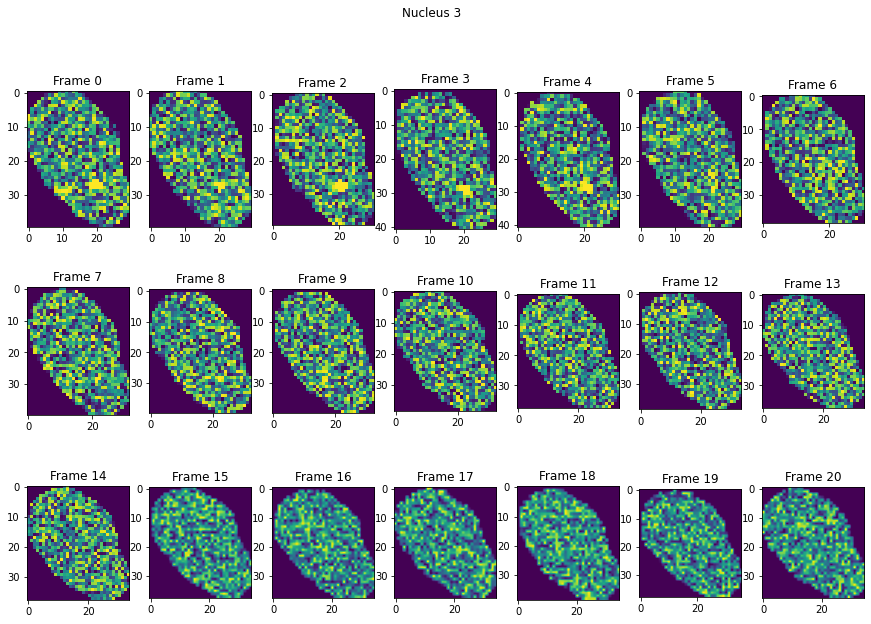

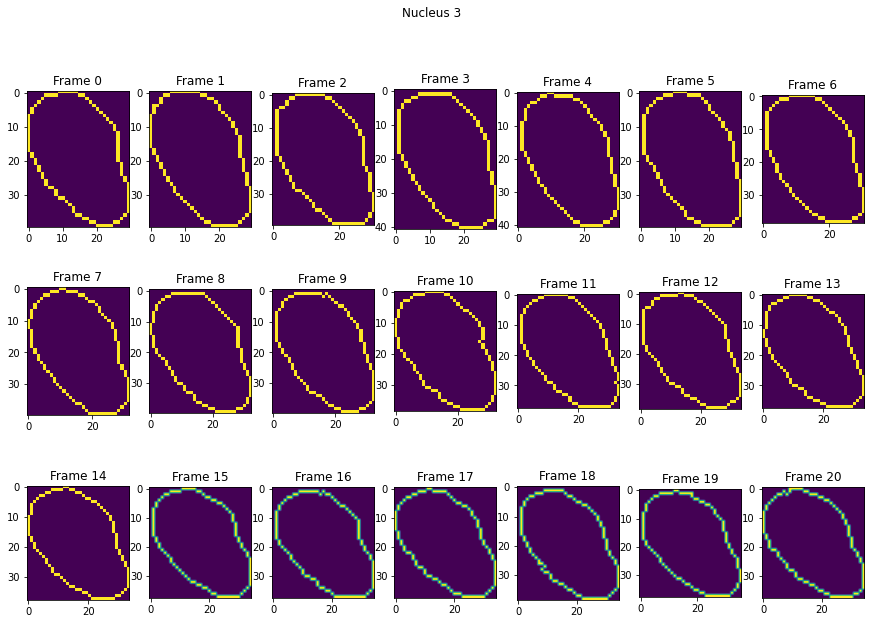

KeyboardInterrupt: ignored

In [ ]:
#print all the nuclei and all the frames


for indx in np.arange(df_patches.shape[0]):
  df = df_patches.loc[indx]
  df_c = df_contours.loc[indx]
  
  fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(15,10))
  fig.suptitle('Nucleus ' + str(indx))
  fig2, axes2 = plt.subplots(nrows=3, ncols=7, figsize=(15,10))
  fig2.suptitle('Nucleus ' + str(indx))

  
  for ind,row in enumerate(df):
    axes.flatten()[ind].set_title( 'Frame ' + str(ind)) 
    axes.flatten()[ind].imshow(row)
    axes2.flatten()[ind].set_title( 'Frame ' + str(ind)) 
    axes2.flatten()[ind].imshow(df_c[ind])

  plt.show()

# ***Calculating Trajectory features***

---


In [ ]:
#initial imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from scipy import ndimage 
from scipy.optimize import curve_fit

In [ ]:
#if data on drive 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#read the dataframe

df = pd.read_pickle('OUTPUT_PATH/dfroi.pickle')
df

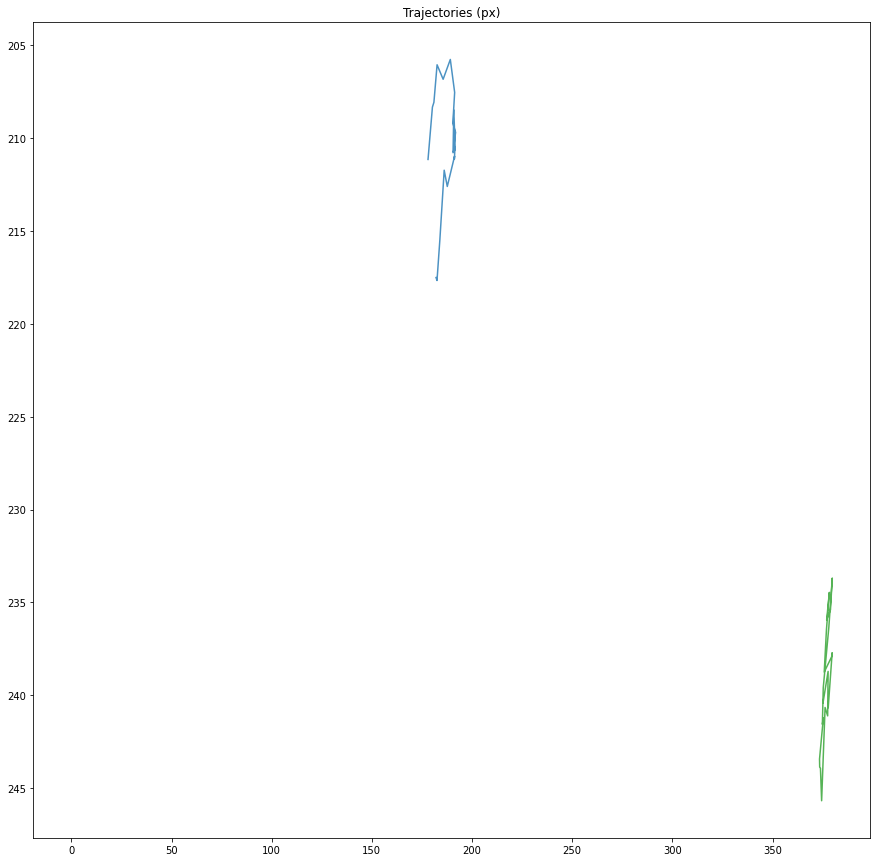

In [ ]:
#plot motion in 2d coordinates

indexes = np.unique(df.index)

x_max = -np.Infinity
x_min = np.Infinity

fig,ax = plt.subplots(figsize=(15,15))
plt.title('Trajectories (px)')

for i in indexes:
  df_t = df.loc[i]
  df_t = df_t.sort_values(by=['timeframe'])

  bb_coords = df_t['centroid'].values #plot coordinates of centroid
  
  
  x = []
  y = []
  for coord in bb_coords:

    x.append(coord[0])
    y.append(coord[1])

  x = np.array(x)
  y = np.array(y)
  if x.max() > x_max:
    x_max = x.max()
  if x.min()< x_min:
    x_min = x.min()

  line = ax.plot(y,x, 10, alpha = 0.8)


leverage = (x_max - x_min)/20

ax.set_ylim((x_max + leverage, x_min -  leverage))

plt.show()

In [ ]:
#calculating features


particles = np.unique(df['particle'].values)
timeframes = np.unique(df['timeframe'])


#save features
orientation_t = []
norm_t = []
norm_tx = []
norm_ty = []



distances = pd.DataFrame(index = timeframes, columns=particles) #saves distances at each timeframe
distancesx = pd.DataFrame(index = timeframes, columns=particles) #saves distances for axis x at each timeframe
distancesy = pd.DataFrame(index = timeframes, columns=particles) #saves distances for axis y at each timeframe
orientations = pd.DataFrame(index = timeframes, columns=particles) #saves orientation of step at each timeframe
coordsx = pd.DataFrame(index = timeframes, columns=particles) #saves coordinates in x axis 
coordsy = pd.DataFrame(index = timeframes, columns=particles) #saves coordinates in y axis
df_traj = pd.DataFrame(index = particles) #saves all features for trajectory, for each nucleus



for indx in particles:
  df_part = df.loc[df['particle'] == indx] #go particle by particle
  df_part = df_part.sort_values(by = ['timeframe'])
  df_part.index = np.arange(df_part.shape[0])

  #mostly calculating net values
  centers = df_part['centroid'].values
  init = np.array(centers[0])
  end = np.array(centers[-1])
  norm = np.linalg.norm(end-init)
  norm_t.append(norm)
  norm_tx.append(end[0]-init[0])
  norm_ty.append(end[1]-init[1])
  vector = np.array(end) - np.array(init)
  angle_g = np.arctan2(-vector[0],vector[1])
  orientation_t.append(angle_g)

  #going frame-by-frame

  for idx, row in df_part.iterrows():
    if idx == 0:
      prev_c = np.asarray(row['centroid'])
      prev_cx = np.asarray(row['centroid x'])
      prev_cy = np.asarray(row['centroid y'])

    norm_p = np.linalg.norm(np.array(row['centroid']) - prev_c)
    normx_p = np.linalg.norm(np.array(row['centroid x']) - prev_cx)
    normy_p = np.linalg.norm(np.array(row['centroid y']) - prev_cy)
    
    vector = np.array(row['centroid']) - prev_c
    angle = np.arctan2(-vector[0],vector[1])
    
    prev_c = np.array(row['centroid'])
    prev_cx = np.array(row['centroid x'])
    prev_cy = np.array(row['centroid y'])

    coordsx.iat[idx,indx] = row['centroid x']
    coordsy.iat[idx,indx] = row['centroid y']
    distances.iat[idx,indx] = norm_p
    distancesx.iat[idx,indx] = normx_p
    distancesy.iat[idx,indx] = normy_p 

    orientations.iat[idx,indx] = angle


#correcting for limitations of the angle calculation function
for columnName, columnData in orientations.iteritems():

  unwraped = np.unwrap(columnData, discont = 6)
  orientations[columnName] = unwraped


df_traj['Net Orientation'] = orientation_t #angle between initial and final positions
df_traj['Net Displacement'] = norm_t #total distance (euclidean)
df_traj['Net Displacement X'] = norm_tx #total distance, x axis
df_traj['Net Displacement Y'] = norm_ty #total distance, y axis

#get total distances

total_dist = []
total_distx = []
total_disty = []
mean_step = []
std_step = []

for columnName, columnData in distances.iteritems():

  dist = np.sum(columnData)
  mean_step.append(np.mean(columnData))
  std_step.append(np.std(columnData))

  total_dist.append(dist)

for columnName, columnData in distancesx.iteritems():

  dist = np.sum(columnData)
  total_distx.append(dist)

for columnName, columnData in distancesy.iteritems():

  dist = np.sum(columnData)
  total_disty.append(dist)

df_traj['Mean Step Displacement'] = mean_step #mean step distance in T
df_traj['Std Step Displacement'] = std_step #std deviation of step distance in T
df_traj['Total Distance'] = total_dist #total euclidean distance across time frames
df_traj['Total Distance X'] = total_distx #total x distance across time frames
df_traj['Total Distance Y'] = total_disty #total y distance across time frames
df_traj['Efficiency'] = df_traj['Net Displacement'].values / np.array(total_dist) #migration efficiency: net distance over total distance

#now, some orientation features

mean_ang = []
std_ang = []
tot_ang = []
avg_straight = []
avg_bend = []
mean_abs_ang = []
std_abs_ang = []
mean_dir = []

for columnName, columnData in orientations.iteritems():
  
  mean_ang.append(np.mean(columnData))
  mean_abs_ang.append(np.mean(np.abs(columnData)))
  std_ang.append(np.std(columnData))
  std_abs_ang.append(np.std(np.abs(columnData)))
  tot_ang.append(np.sum(np.abs(columnData)))
  avg_straight.append(np.sum(np.cos(columnData)) / columnData.shape[0])
  avg_bend.append(np.sum(np.sin(columnData)) / columnData.shape[0])
  dir = []
  for ind, row in enumerate(columnData):
    if ind == 0:
      prev = row
    else:
      cur = row
      dir.append(np.abs(cur - prev))
  mean_dir.append(np.mean(dir))

df_traj['Mean Step Orientation'] = mean_ang #mean angle between steps
df_traj['Std Step Orientation'] = std_ang #std deviation of distribution of angle between steps
df_traj['Mean Abs Step Orientation'] = mean_abs_ang #mean angle between steps (in absolute value)
df_traj['Std Abs Step Orientation'] = std_abs_ang #std deviation of distribution of angle between steps (in absolute value)
df_traj['Total Step Orientation'] = tot_ang #total orientation variation (sum of all angles between steps in abs value)
df_traj['Average Straightness'] = avg_straight #straightness - defined as the mean cosine of the angle between steps
df_traj['Average Bending'] = avg_bend #bending - defined as the mean sine of the angle between steps
df_traj['Mean Direction Variation'] = mean_dir #mean direction

df_traj

In [ ]:
#Calculate MSD (um)

MSDs = pd.DataFrame(index = timeframes, columns=particles) #saves msd for each particle, at each tf

MSDs.loc[0] = np.zeros(MSDs.shape[1])
for columnName in coordsx.columns:
  xs = coordsx[columnName]
  ys = coordsy[columnName]

  for lag in np.arange(1, xs.shape[0]):
    msd_lag = []
    for ind, row in enumerate(xs):
      x_prev = row
      y_prev = ys[ind]
      
      if (ind + lag) < xs.shape[0]:
        x = xs[ind + lag]
        y = ys[ind + lag]
        msd_temp =  np.power((x-x_prev),2) + np.power((y-y_prev),2) #calculates MSD for that lag
        msd_lag.append(msd_temp)

      else:
        break
      
    avg_lag = np.mean(np.array(msd_lag))

    MSDs.iat[lag,columnName] = avg_lag

MSDs

In [ ]:
#calculate powerlaw

# Function to calculate the power-law with constants a and b
def power_law(x, D, beta):
  """
  input for f, in curve_fit function (from scipy)
  ...
  Inputs for curve_fit
  f — function used for fitting (in this case exponential)
  xdata — array of x-data for fitting
  ydata — array of y-data for fitting
  p0 — array of initial guesses for the fitting parameters (both a and b as 0)
  bounds — bounds for the parameters (-∞ to ∞)
  Outputs
  pars — array of parameters from fit (in this case [a, b])
  cov — the estimated covariance of pars which can be used to determine the standard deviations of the fitting parameters (square roots of the diagonals)
  """
  return D*np.power(x, beta)

time_interval = 3 #TIME IN MINUTES, MAY NEED TO CHANGE


x = MSDs.index[1:]*time_interval


Ds = []
betas = []
stdevs = []
resds = []
rs = []

#for plotting
fig, ax = plt.subplots(figsize = (15,15))

# Set the x and y-axis scaling to logarithmic
ax.set_xscale('log')
ax.set_yscale('log')

# Edit the major and minor tick locations of x and y axes
ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(base=10.0))



for columnName,columnData in MSDs.iteritems():

  columnData = np.array(columnData).astype(float)[1:]


  ax.scatter(x,columnData, s = 3, alpha = 0.5) #plot
  

  pars, cov = curve_fit(f = power_law, xdata = x, ydata = columnData, method = 'lm') #fits data to a power law
  Ds.append(pars[0]) #saves D
  betas.append(pars[1]) #saves exponentn index
  ax.plot(x,power_law(x,pars[0],pars[1]), alpha = 0.5)

  # Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
  stdev = np.sqrt(np.diag(cov))
  stdevs.append(stdev)
  # Calculate the residuals
  res = columnData - power_law(x, *pars)
  resds.append(res)
  correlation_matrix = np.corrcoef(columnData,power_law(x,pars[0],pars[1]))
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  rs.append(r_squared)
  

df_traj['D'] = Ds
df_traj['beta'] = betas
df_traj['Std (powerlaw)'] = stdevs
df_traj['Residuals (powerlaw)'] = resds
df_traj['R2'] = rs

df_traj

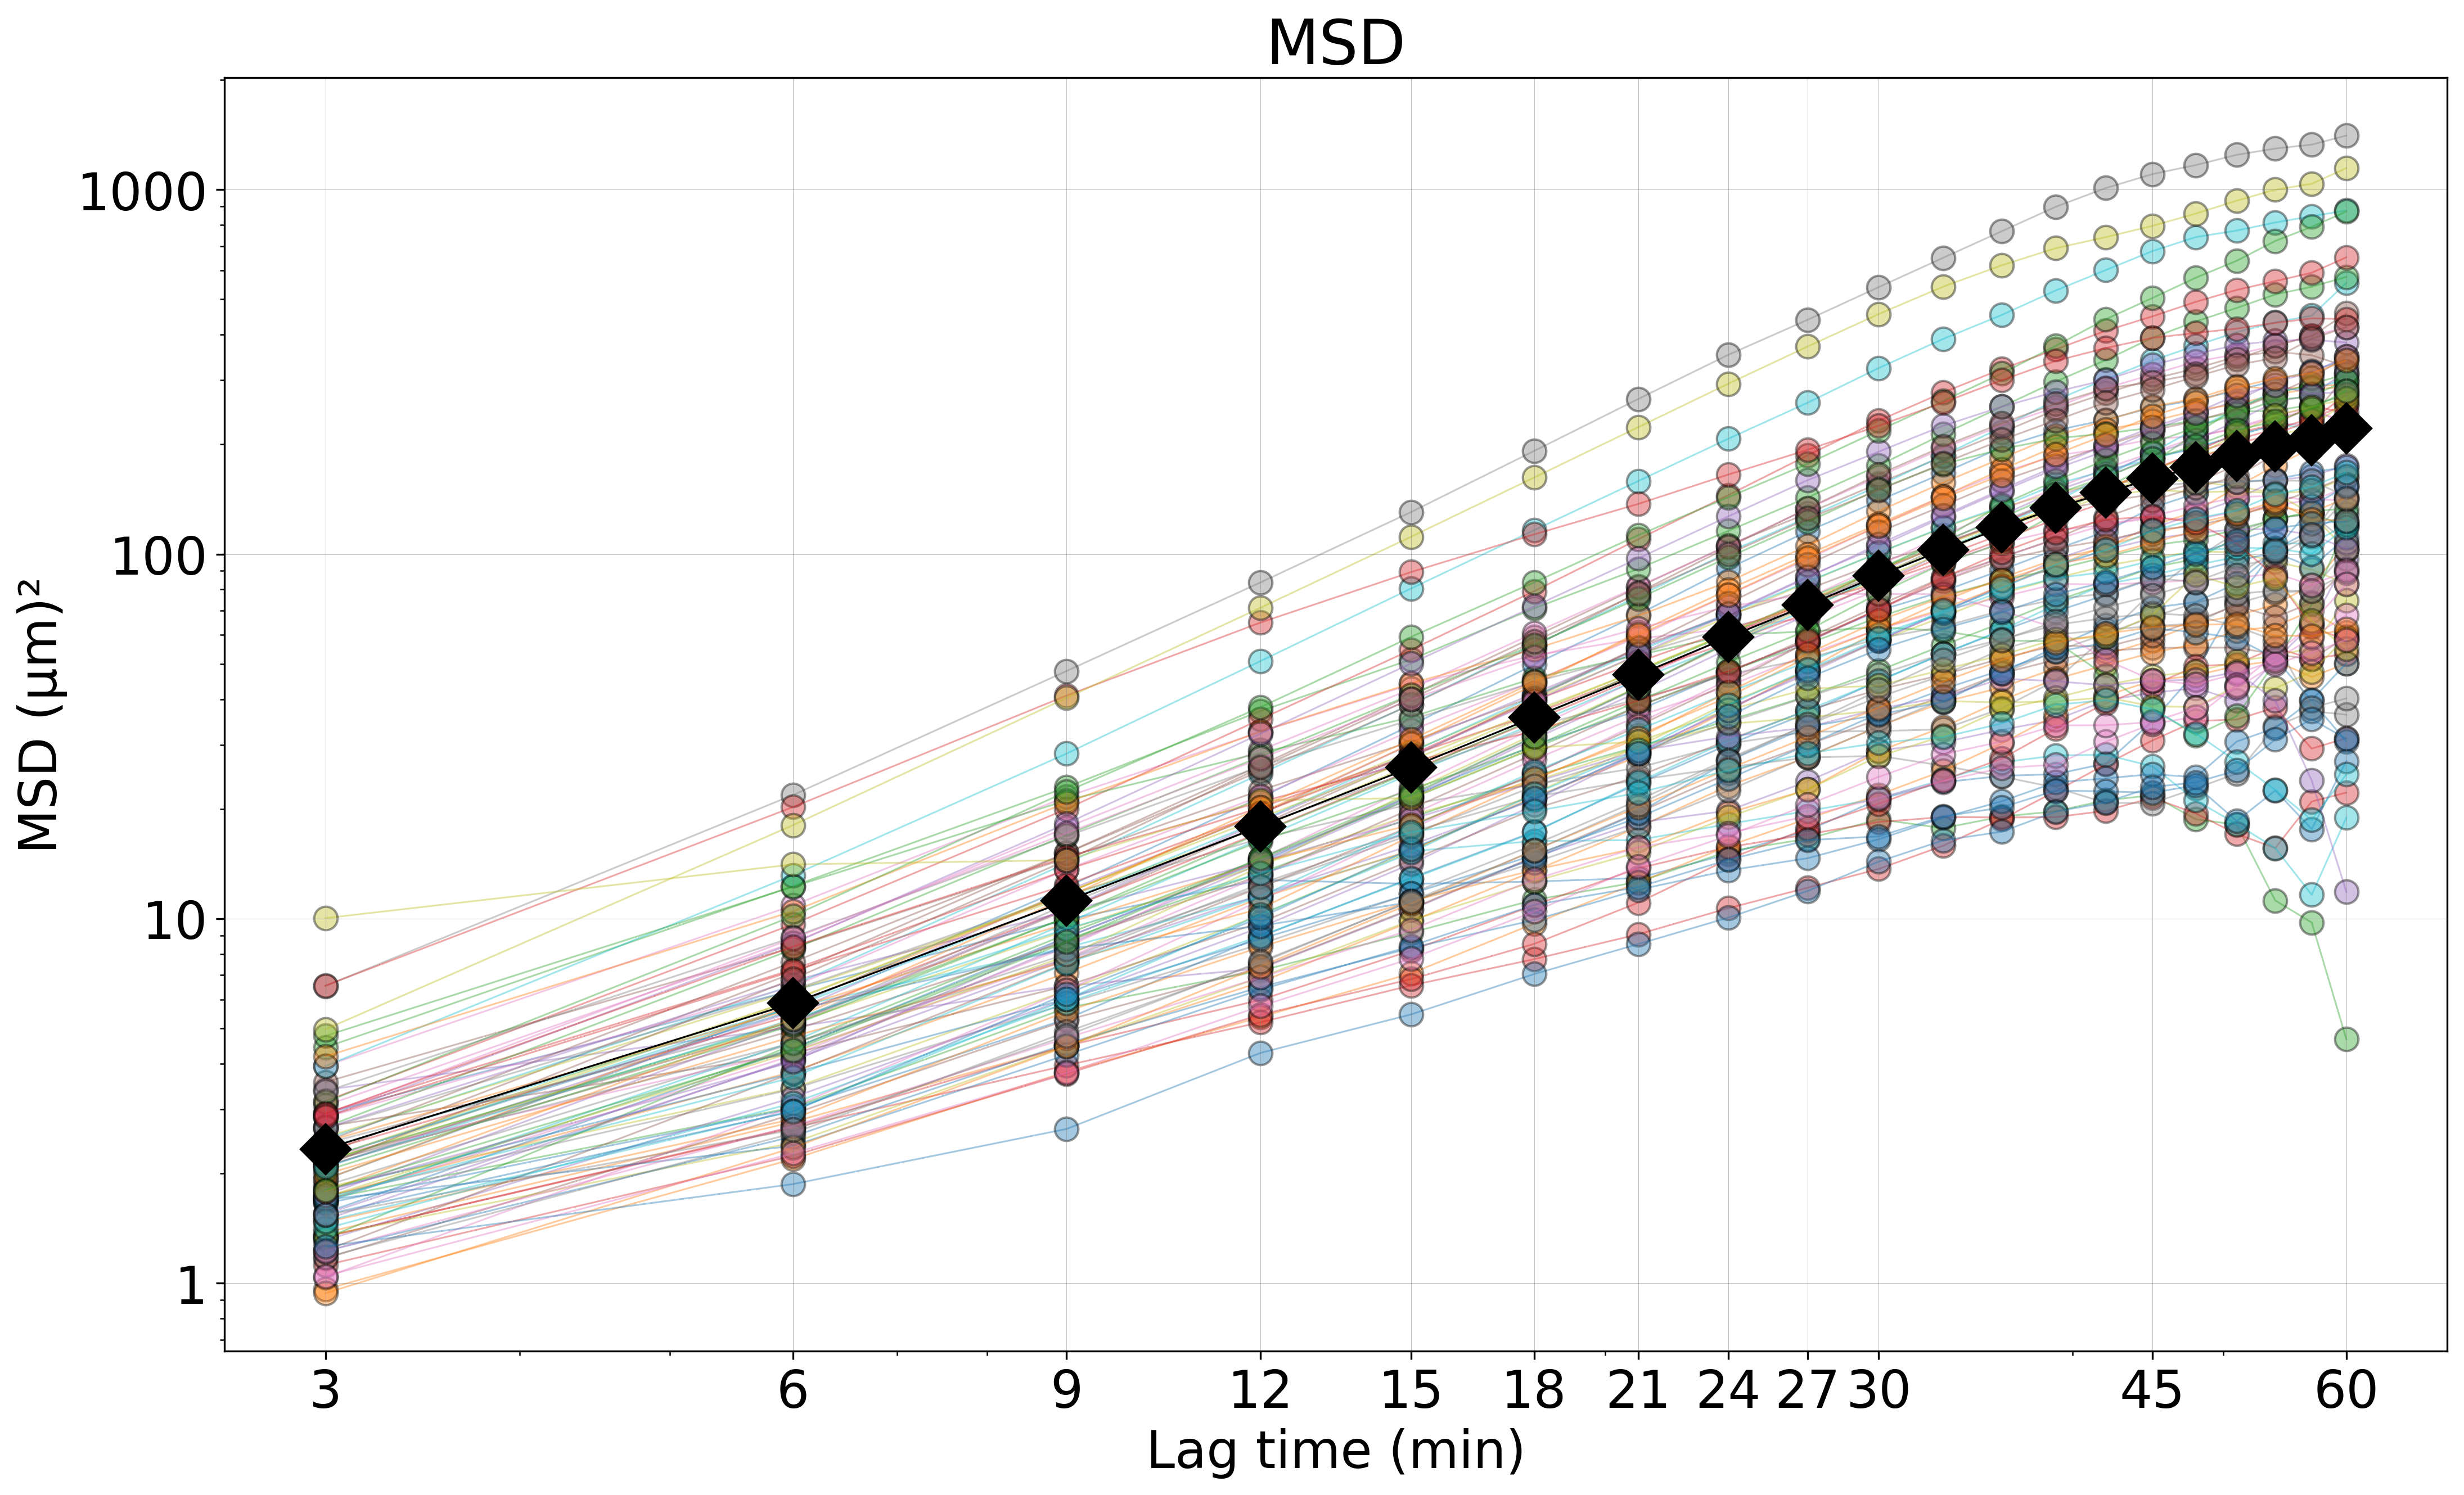

0       0.000000
3       2.335015
6       5.866807
9      11.185939
12     17.924388
15     26.013381
18     35.710893
21     46.631520
24     59.167730
27     72.546706
30     87.352915
33    102.687687
36    118.277942
39    133.877360
42    147.484022
45    161.134593
48    173.130950
51    185.834395
54    197.756462
57    205.500049
60    221.006263
dtype: float64

In [ ]:
#plots MSDs

def point_plot(MSDs, time_interval, histogram = True):
  """
  Plots MSDs, calculates avg MSD
  """

  from seaborn import pointplot as pointplot
  import seaborn as sns
  from matplotlib.colors import LinearSegmentedColormap
  import matplotlib.patches as mpatches
  import matplotlib as mpl
  mpl.rcParams.update({'font.size': 22})
  

  #plotting parameters
  fig, ax = plt.subplots(figsize=(17,10), dpi = 300)
  mpl.rcParams['lines.markersize'] = 10
  ax.set(xscale="log", yscale = "log")
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)



  for columnName,columnData in MSDs.iteritems():
      
      msds = columnData
      msds.index = np.arange(msds.shape[0])*time_interval
      ax.plot(msds.index[1:], msds.values[1:], linewidth = 0.75,markersize = 10, marker = 'o', mec='k',zorder = 0, alpha = 0.4)

  #more plot parameters
  ax.set_xticks([3,6,9,12,15,18,21,24,27,30,45,60])
  ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
  ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

  ax.set_title('MSD')
  ax.set_ylabel('MSD (\u03BC'+'m)\u00b2')
  ax.set_xlabel('Lag time (min)')
  
  ax.set_axisbelow(True)
  ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


  #average MSD
  avg_msd = MSDs.mean(axis = 1)
  avg_msd.index = np.arange(avg_msd.shape[0])*time_interval
  ax.plot(avg_msd.index[1:], avg_msd[1:], linewidth = 0.75, c = 'k', markersize = 15, marker = 'D', mec='k',zorder = 1)
  
  plt.show()

  return avg_msd



#ADJUST TIME INTERVAL
time_interval = 3 #min

avg_msd = point_plot(MSDs, time_interval, True)

avg_msd

In [ ]:
#save dfs
df_traj.to_pickle('OUTPUT_PATH/all_traj.pickle')
MSDs.to_pickle('OUTPUT_PATH/MSDs.pickle')

# ***Calculating Dynamic features*** 

---


In [ ]:
#imports
import pandas as pd
import numpy as np
from RegionPropsMorph import RegionPropsMorph

In [ ]:
#if files on drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#read the pandas dataframe

df_all = pd.read_pickle('OUTPUT_PATH/dfroi.pickle')
df_all

In [ ]:
#calculate features

df_base = df_all['Patch'] 

df = pd.DataFrame(data = df_all.values, columns = df_all.columns)

final_morph = [] #morphological features


for index, row in enumerate(df_base):

        patch = row

        #calculate features
        propsmorph = RegionPropsMorph(patch)
        
        #obtain feature labels (invariant) and their values
        morph_labels, morph_values = propsmorph.print_features(print_values = False) #change to true to see feature values

        #add each feature to its respective list, which will then be put into the dataframe
        for i in np.arange(len(morph_values)):
          if len(final_morph) < len(morph_values):
                  final_morph.append([morph_values[i]])
          else:
              final_morph[i].append(morph_values[i])

      
#add features to dataframe and visualize

for i in np.arange(len(morph_labels)):
    df[morph_labels[i]] = final_morph[i]


df

In [ ]:
#save the new dataframe

df.to_pickle('OUTPUT_PATH/dfroi.pickle')

#if wanting to save to xlsx file, uncomment the following:
#excel_name = 'all.xlsx'
#df_path =  excel_name
#df_all.to_excel(df_path) 


# ***Dynamic Feature Analysis*** 

---


In [ ]:
#imports
import pandas as pd
import numpy as np

In [ ]:
#if files in drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#read the pandas dataframe

df = pd.read_pickle('OUTPUT_PATH/dfroi.pickle')
df

In [ ]:
#select columns to calculate relative values of

features = ['FEATURES SELECTED']

In [ ]:
#calculate relative values, as percentage, absolute percentage and net change

df_variation = pd.DataFrame() #relative variation as %
df_abs_variation = pd.DataFrame()  #absolute relative variation as %

df_net_variation = pd.DataFrame() #relative net variation of features as %



for feat in features: #go feature by feature

  df_feats = df[[feat, 'particle', 'timeframe']]
  net_vars = []
  relative_list = []
  relative_abs_list = []

  particle_no = [] #saves particle
  frames = [] #saves frames
                
  for particle in np.unique(df_feats['particle'].values): #go particle by particle

    df_feat = df_feats.loc[df_feats['particle'] == particle]

    df_feat = df_feat.sort_values(by = 'timeframe')

    
    

    particle_no.extend([particle]*(df_feat.shape[0] - 1))
    frames.extend(df_feat['timeframe'].values[1:])

  
    for ind, value in enumerate(np.array(df_feat[feat])): #go frame by frame

      if ind == 0:
        prev_feat = value

      else:
        new_feat = value
        delta = ((new_feat - prev_feat) / prev_feat)*100   #given as a percentage of the value from the previous frame
        delta_abs = np.abs(delta) #absolute relative variation

        relative_list.append(delta)
        relative_abs_list.append(delta_abs)

    

    first = df_feat.loc[df_feat['timeframe'] == 0][feat].values[0]
    last = df_feat.loc[df_feat['timeframe'] == np.max(df_feat['timeframe'])][feat].values[0]
    net_var = ((first-last/first))*100 #net variation, as a % of the value for the initial frame

    net_vars.append(net_var)

  df_variation[feat] = relative_list
  df_abs_variation[feat] = relative_abs_list

  df_net_variation[feat] = net_vars

df_variation['particle'] = particle_no
df_abs_variation['particle'] = particle_no
df_net_variation['particle'] = np.unique(np.array(particle_no))

df_variation['timeframe'] = frames
df_abs_variation['timeframe'] = frames


df_net_variation
